#                                    WEATHER IMAGE PREDICTION

## About Dataset:-

* dataset contains 6862 images of different types of weather, it can be used to implement weather classification based on the photo
* The pictures are divided into 11 classes: dew, fog/smog, frost, glaze, hail, lightning , rain, rainbow, rime, sandstorm and snow.

## Import Libarary

In [54]:
import os
import shutil
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

### value counts of classification:

In [55]:
for i in os.listdir('D:\\archive\\dataset'):
    print(len(os.listdir('D:\\archive\\dataset\\' + str(i))))

698
851
475
639
591
377
526
232
1160
692
621


# Data Preprocessing

## *File path:

In [56]:
image_loc = 'D:\\archive\\dataset'

In [57]:
class_loc = []
for i in os.listdir(image_loc):
    class_loc.append(os.path.join(image_loc,i))

In [58]:
class_loc

['D:\\archive\\dataset\\dew',
 'D:\\archive\\dataset\\fogsmog',
 'D:\\archive\\dataset\\frost',
 'D:\\archive\\dataset\\glaze',
 'D:\\archive\\dataset\\hail',
 'D:\\archive\\dataset\\lightning',
 'D:\\archive\\dataset\\rain',
 'D:\\archive\\dataset\\rainbow',
 'D:\\archive\\dataset\\rime',
 'D:\\archive\\dataset\\sandstorm',
 'D:\\archive\\dataset\\snow']

In [59]:
image_path = []
for i in class_loc:
    for j in os.listdir(i):
        image_path.append(os.path.join(i,j))

### *DataFrame of Path & Label

In [60]:
img_df = pd.DataFrame(image_path, columns = ['path'])

In [61]:
img_df['label'] = None

In [62]:
for i,j in enumerate(img_df['path']):
    img_df['label'][i] = img_df['path'][i].split('\\')[3]

In [63]:
img_df

,path,label
0,D:\archive\dataset\dew\2208.jpg,dew
1,D:\archive\dataset\dew\2209.jpg,dew
2,D:\archive\dataset\dew\2210.jpg,dew
3,D:\archive\dataset\dew\2211.jpg,dew
4,D:\archive\dataset\dew\2212.jpg,dew
...,...,...
6857,D:\archive\dataset\snow\1446.jpg,snow
6858,D:\archive\dataset\snow\1447.jpg,snow
6859,D:\archive\dataset\snow\1448.jpg,snow
6860,D:\archive\dataset\snow\1449.jpg,snow


## *Visualization:

In [64]:
unique_labels = img_df['label'].unique()
unique_labels

array(['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain',
       'rainbow', 'rime', 'sandstorm', 'snow'], dtype=object)

In [65]:
examples = pd.DataFrame([])
for label in unique_labels:
    examples = pd.concat([examples, img_df.query(f"label == '{label}'").sample(1)])

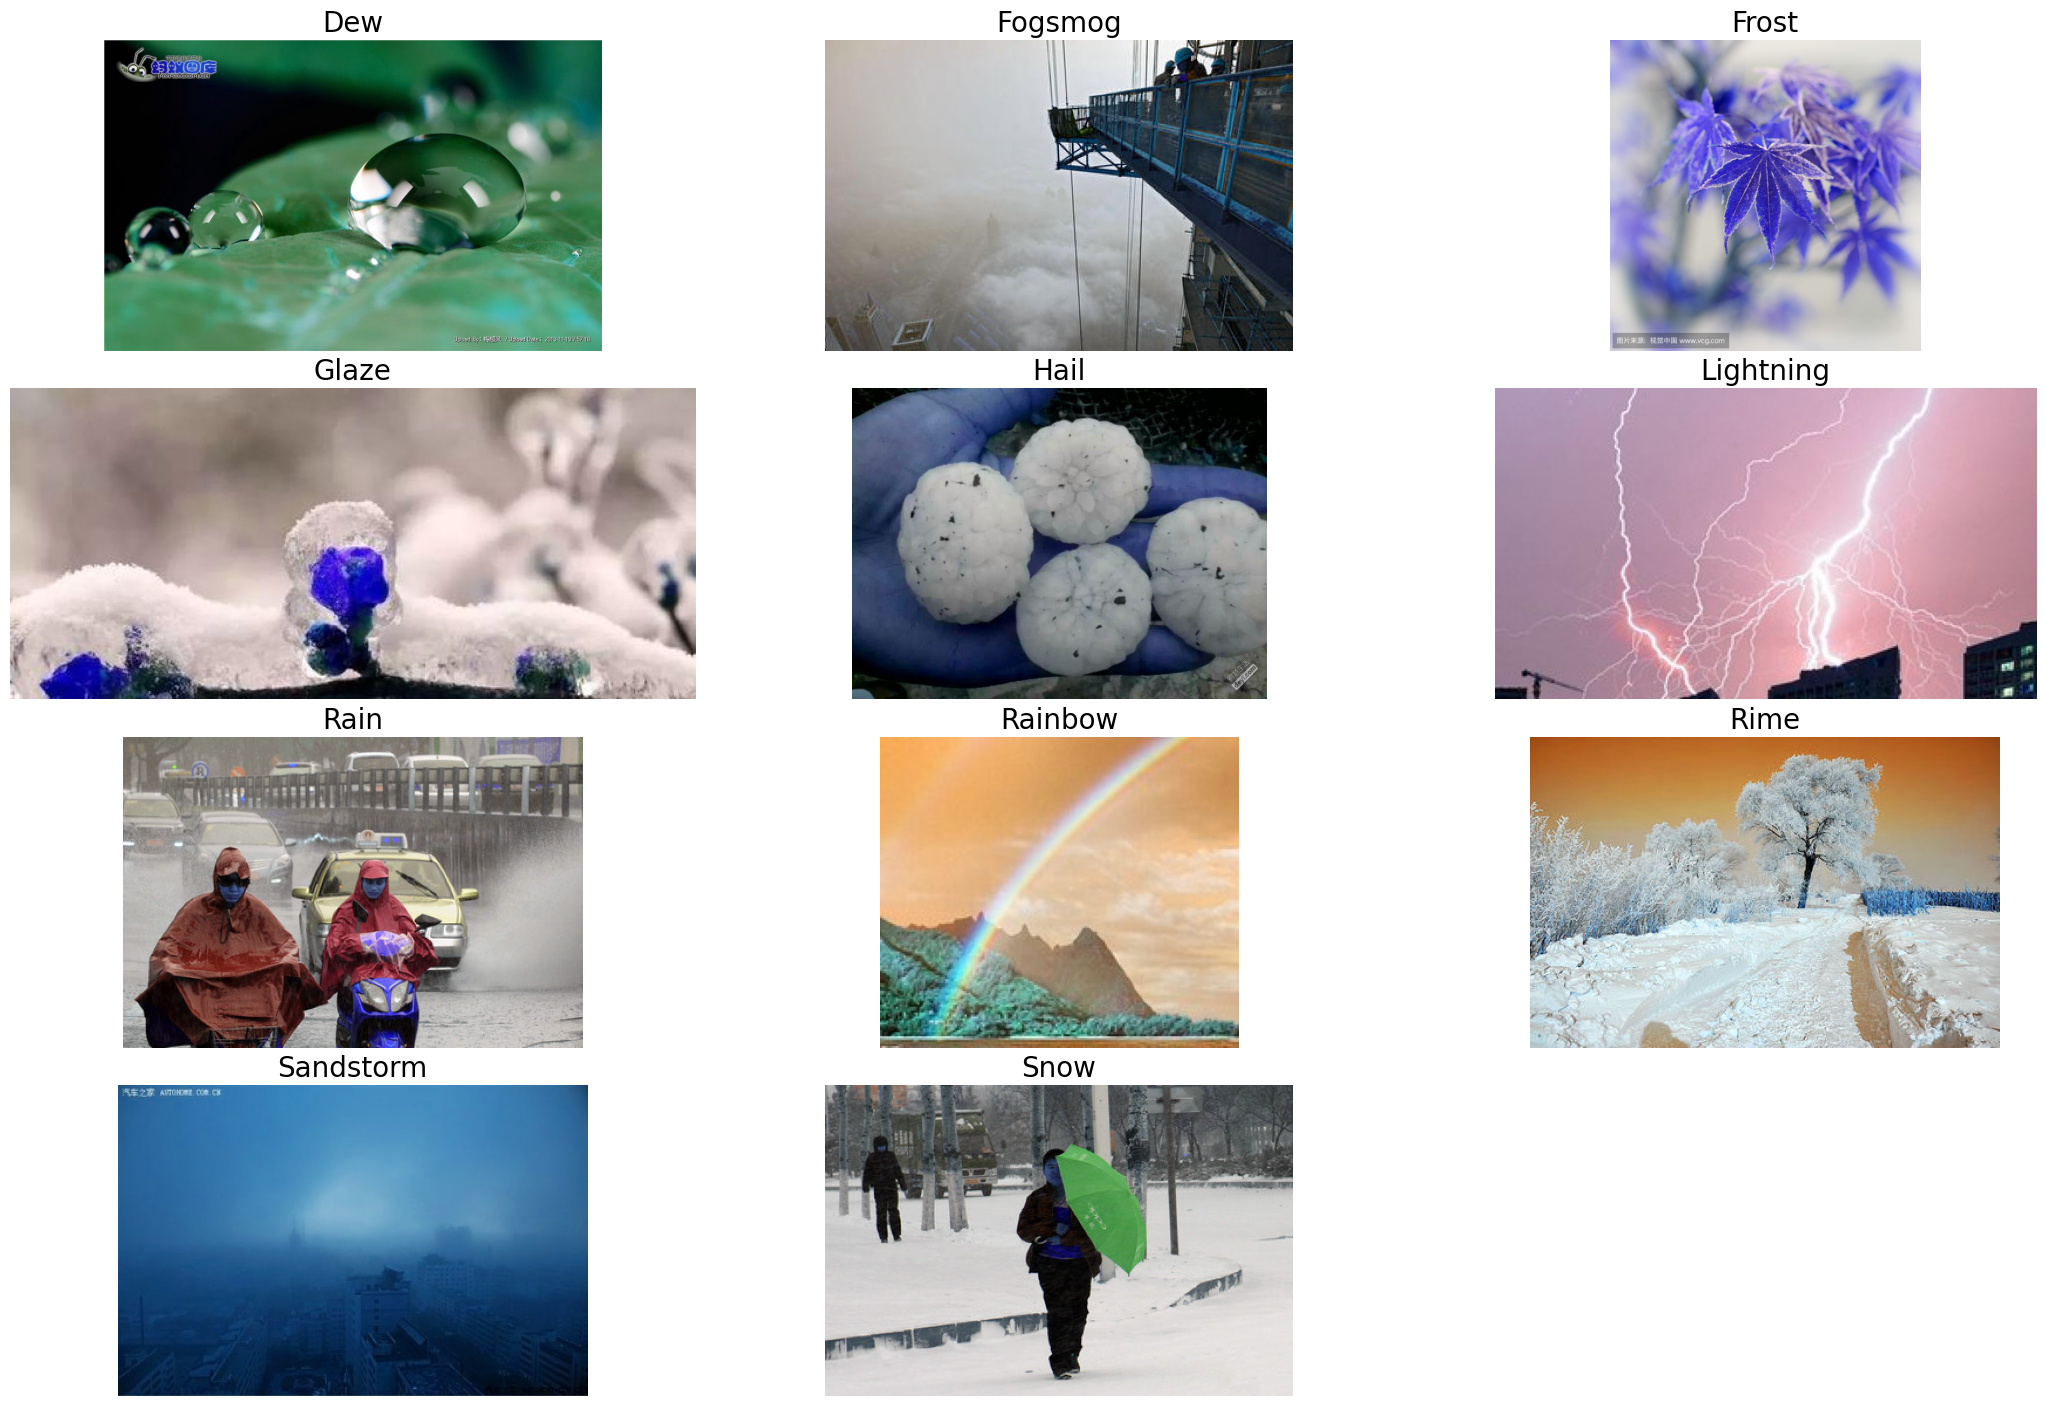

In [114]:

fig = plt.figure(figsize=(22, 14))
for index, row in examples.reset_index().iterrows():
    ax = plt.subplot(4, 3, index + 1)
    image = cv2.imread(row["path"])
    plt.imshow(image)
    ax.set_title(row["label"].title(), fontsize=20)
    ax.axis("off")

fig.tight_layout(pad=0.5)
plt.show()

## *Train & Test Split

In [67]:
train,test = train_test_split(img_df, test_size = 0.2, stratify = img_df['label'])
train.to_csv('D:\\archive\\train.csv', index = False)
test.to_csv('D:\\archive\\test.csv', index = False)

## 1.Train Files:

## 2.Test Files:

## *Image_resize:

In [68]:
def image_resize(width, height, data):
    
    images = []

    for image_path in tqdm(data['path']):
    
        img = cv2.imread(image_path)
        
        if img is not None and img.size > 0: 

            resized_img = cv2.resize(img, (width,height), interpolation = cv2.INTER_AREA)

            img_array = np.array(resized_img)

            images.append([image_path.split('\\')[-1] , img_array])
        
    return images

In [69]:
train_images = image_resize(256,256,train)
test_images = image_resize(256,256,test)

100%|██████████████████████████████████████████████████████████████████████████████| 1373/1373 [00:26<00:00, 51.68it/s]


## *Image_Data_Generator:

In [89]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.1,
                                  zoom_range = 0.1,
                                  horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

# Training Set
train_set = train_datagen.flow_from_directory('D:/archive/train',
                                             target_size = (256,256),
                                             batch_size = 4,
                                             class_mode = 'categorical')

# Testing Set
test_set = test_datagen.flow_from_directory('D:/archive/test',
                                           target_size = (256,256),
                                           batch_size = 4,
                                           class_mode = 'categorical',
                                           shuffle = False)

Found 5489 images belonging to 11 classes.
Found 1373 images belonging to 11 classes.


# Model Buiding

In [90]:
classifier = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(16,3,activation='relu',input_shape=(256,256,3)), 
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Conv2D(8,2,activation='relu'),
        tf.keras.layers.MaxPool2D((2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation = 'relu'),
        tf.keras.layers.Dense(11,activation = 'softmax')
    ]
)
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 126, 126, 8)       520       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 63, 63, 8)        0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 31752)             0         
                                                                 
 dense_23 (Dense)            (None, 128)             

# Model Accuracy Score

In [91]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [107]:
model = classifier.fit_generator(generator = train_set, 
                         steps_per_epoch = 1000, 
                         epochs = 5,      
                         validation_data = test_set)

Epoch 1/5
1000/1000 [==============================] - 271s 270ms/step - loss: 0.6827 - accuracy: 0.7636 - val_loss: 1.0342 - val_accuracy: 0.6839
Epoch 2/5
1000/1000 [==============================] - 280s 280ms/step - loss: 0.6447 - accuracy: 0.7788 - val_loss: 0.9992 - val_accuracy: 0.6861
Epoch 3/5
1000/1000 [==============================] - 294s 294ms/step - loss: 0.6534 - accuracy: 0.7857 - val_loss: 1.1258 - val_accuracy: 0.6926
Epoch 4/5
1000/1000 [==============================] - 289s 289ms/step - loss: 0.6175 - accuracy: 0.7906 - val_loss: 1.2848 - val_accuracy: 0.6511
Epoch 5/5
1000/1000 [==============================] - 274s 274ms/step - loss: 0.6185 - accuracy: 0.7988 - val_loss: 1.0871 - val_accuracy: 0.6875


In [108]:
classifier.predict(test_set)

344/344 [==============================] - 24s 69ms/step


array([[9.9999893e-01, 4.2530261e-15, 1.3056379e-08, ..., 4.3826706e-11,
        1.1512151e-16, 3.8660226e-13],
       [1.0000000e+00, 4.5455949e-18, 4.1926024e-10, ..., 1.0323187e-14,
        7.2758928e-21, 1.1313954e-14],
       [9.9858785e-01, 4.0435161e-10, 1.4821889e-05, ..., 4.0428088e-09,
        1.4353755e-13, 1.3190287e-06],
       ...,
       [9.6280301e-06, 3.5088243e-10, 3.0282079e-04, ..., 1.7157202e-03,
        4.8216219e-17, 9.6008044e-01],
       [5.8268684e-05, 3.2319929e-06, 1.8009194e-03, ..., 7.4570835e-02,
        5.8002469e-10, 8.5433084e-01],
       [1.4545688e-02, 6.8757521e-13, 7.5699401e-01, ..., 8.4451959e-02,
        1.1818000e-22, 8.6911425e-02]], dtype=float32)

In [109]:
y_pred = classifier.predict(test_set)

344/344 [==============================] - 23s 67ms/step


In [110]:
np.argmax(y_pred, axis=-1)

array([ 0,  0,  0, ..., 10, 10,  2], dtype=int64)

In [111]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [112]:
le = LabelEncoder()
le.fit_transform(test['label'])

array([0, 8, 8, ..., 8, 1, 4])

In [113]:
print(classification_report(le.fit_transform(test['label']), np.argmax(y_pred, axis=-1)))

              precision    recall  f1-score   support

           0       0.10      0.10      0.10       140
           1       0.10      0.11      0.11       170
           2       0.03      0.02      0.03        95
           3       0.09      0.09      0.09       128
           4       0.10      0.11      0.10       118
           5       0.07      0.05      0.06        76
           6       0.07      0.06      0.06       105
           7       0.09      0.07      0.08        46
           8       0.16      0.18      0.17       232
           9       0.11      0.11      0.11       139
          10       0.08      0.10      0.09       124

    accuracy                           0.10      1373
   macro avg       0.09      0.09      0.09      1373
weighted avg       0.10      0.10      0.10      1373



                                               *THANK YOU*